# Pricing Strategy Development
This is a multi-step tool to support the development of the price strategy, in an automated way.   

- Step 1: Libraries & connection to database
- Step 2: Identify Anchors
- Step 3: Identify Pairs
- Step 4: Identify Optimal Price Index vs Pair for each Anchor

# Step 1: Libraries & connection to database

In [1]:
# !pip install pythonnet
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install datetime
# !pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
# import ssas_api as ssas
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
import warnings

# Suppress the specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", category=UserWarning)

## Connect to database

In [4]:
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'retail_price.csv')
retail_price = pd.read_csv(file_path)
retail_price

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.950000,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.900000
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.950000,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.950000
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.950000,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.950000
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.950000,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.950000
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.950000,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,bed5,bed_bath_table,01-05-2017,1,215.00,8.760000,215.000000,56,162,5,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,214.950000
672,bed5,bed_bath_table,01-06-2017,10,2090.00,21.322000,209.000000,56,162,5,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,215.000000
673,bed5,bed_bath_table,01-07-2017,59,12095.00,22.195932,205.000000,56,162,5,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,209.000000
674,bed5,bed_bath_table,01-08-2017,52,10375.00,19.412885,199.509804,56,162,5,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,205.000000


In [5]:
retail_price.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price'],
      dtype='object')

In [6]:
# Keep only useful columns

retail_price = retail_price[['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'unit_price']]
retail_price

,product_id,product_category_name,month_year,qty,total_price,unit_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,45.950000
1,bed1,bed_bath_table,01-06-2017,3,137.85,45.950000
2,bed1,bed_bath_table,01-07-2017,6,275.70,45.950000
3,bed1,bed_bath_table,01-08-2017,4,183.80,45.950000
4,bed1,bed_bath_table,01-09-2017,2,91.90,45.950000
...,...,...,...,...,...,...
671,bed5,bed_bath_table,01-05-2017,1,215.00,215.000000
672,bed5,bed_bath_table,01-06-2017,10,2090.00,209.000000
673,bed5,bed_bath_table,01-07-2017,59,12095.00,205.000000
674,bed5,bed_bath_table,01-08-2017,52,10375.00,199.509804


# Step 2: Identify Anchors
Use sales data to identify key selling skus of the segment of products in the specific Manufacturer you are building the strategy for.

In [7]:
# Function to identify anchors: receives sales by sku dataframe and returs list of top-10 selling skus

def identify_anchors(df):
    df = df.groupby('product')[['sales']].sum().sort_values('sales', ascending=False)

    limit = df['sales'].sum()*0.001
    df_limited = df[df['sales'] > limit]
    
    plt.figure(figsize=(12,2))
    
    plt.bar(df_limited.index, df_limited['sales'], color='blue')
    plt.title('Sales by sku', fontsize=12)
    plt.xticks(rotation=90, fontsize=6);
    plt.show()

    df_top_10 = df.head(10)
    perc = df_top_10['sales'].sum() / df['sales'].sum()

    print(f"Top 10 represents: {round(perc,2)*100}%")

    return df_top_10.index.to_list()

/var/folders/j4/48d_zp914zjcvl7wg8l5qsqh0000gn/T/ipykernel_76079/2296474996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_by_sku_df.rename(columns={'product_id': 'product',


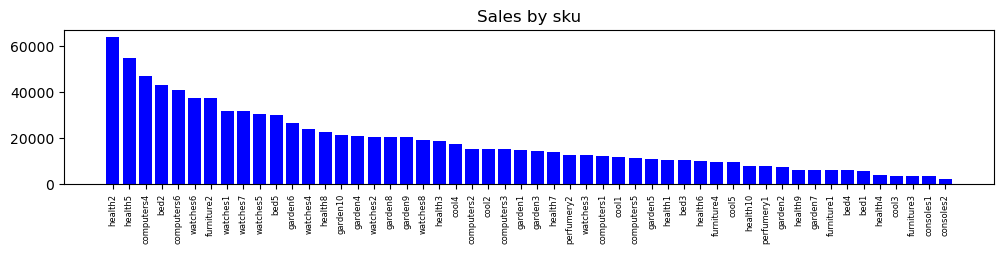

Top 10 represents: 44.0%


['health2',
 'health5',
 'computers4',
 'bed2',
 'computers6',
 'watches6',
 'furniture2',
 'watches1',
 'watches7',
 'watches5']

In [8]:
# Create a 'sales by sku' dataframe that will serve as input for the function that will identify the anchors
sales_by_sku_df = retail_price[['product_id', 'total_price']]
sales_by_sku_df.rename(columns={'product_id': 'product',
                                          'total_price': 'sales'}, inplace=True)

anchors = identify_anchors(sales_by_sku_df)
anchors

The function returns the top 10 selling skus. From those, we selected the skus we will work on.

In [9]:
anchors = ['bed2',
           'watches6',
           'furniture2']

# Step 3: Identify Pairs
During this step, we will use sales data to identify the competitor skus that have the highest impact on each of the anchors' sales. For that, we will evaluate the correlation between price index and volume shares.

In [10]:
# This function will use as input:
    # a database with the following columns: month, manufacturer, count, product, sales_msu, sales_mlc, val_share, vol_share
    # a list with the anchor products

In [11]:
retail_price.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'unit_price'],
      dtype='object')

In [12]:
# need to include value share and volume share data into the database

categ_totals = retail_price.groupby(['product_category_name'])[['total_price', 'qty']].sum().reset_index()
retail_price = retail_price.merge(categ_totals, left_on='product_category_name', right_on='product_category_name', suffixes=('', '_categ_ttl'))
retail_price['val_share'] = retail_price['total_price'] / retail_price['total_price_categ_ttl']
retail_price['vol_share'] = retail_price['qty'] / retail_price['qty_categ_ttl']
retail_price

,product_id,product_category_name,month_year,qty,total_price,unit_price,total_price_categ_ttl,qty_categ_ttl,val_share,vol_share
0,bed1,bed_bath_table,01-05-2017,1,45.95,45.95,95084.52,1026,0.000483,0.000975
1,bed1,bed_bath_table,01-06-2017,3,137.85,45.95,95084.52,1026,0.001450,0.002924
2,bed1,bed_bath_table,01-07-2017,6,275.70,45.95,95084.52,1026,0.002900,0.005848
3,bed1,bed_bath_table,01-08-2017,4,183.80,45.95,95084.52,1026,0.001933,0.003899
4,bed1,bed_bath_table,01-09-2017,2,91.90,45.95,95084.52,1026,0.000967,0.001949
...,...,...,...,...,...,...,...,...,...,...
671,furniture1,furniture_decor,01-04-2018,17,595.00,35.00,56925.16,894,0.010452,0.019016
672,furniture1,furniture_decor,01-05-2018,11,385.00,35.00,56925.16,894,0.006763,0.012304
673,furniture1,furniture_decor,01-06-2018,13,455.00,35.00,56925.16,894,0.007993,0.014541
674,furniture1,furniture_decor,01-07-2018,10,350.00,35.00,56925.16,894,0.006148,0.011186


In [13]:
retail_price.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'unit_price', 'total_price_categ_ttl', 'qty_categ_ttl',
       'val_share', 'vol_share'],
      dtype='object')

In [14]:
# Create a dataframe that will serve as input for the function that will identify the pairs
filtered_df = retail_price

filtered_df['count'] = 1

# filtered_df['month_year'] = filtered_df['month_year'].apply(lambda x: datetime.strptime(x, "%b'%y"))
filtered_df = filtered_df.rename(columns={'month_year': 'date',
                                          'product_category_name': 'manufacturer',
                                          'product_id': 'product',
                                          'total_price': 'sales_mlc',
                                          'qty': 'sales_msu'})
filtered_df = filtered_df.groupby(['date', 'manufacturer', 'count', 'product'])[['sales_msu', 'sales_mlc', 'val_share', 'vol_share']].sum().reset_index()
filtered_df

,date,manufacturer,count,product,sales_msu,sales_mlc,val_share,vol_share
0,01-01-2017,health_beauty,1,health5,8,2799.20,0.013178,0.004343
1,01-01-2017,health_beauty,1,health7,1,64.99,0.000306,0.000543
2,01-01-2018,bed_bath_table,1,bed1,19,759.81,0.007991,0.018519
3,01-01-2018,bed_bath_table,1,bed2,17,1477.30,0.015537,0.016569
4,01-01-2018,bed_bath_table,1,bed3,11,1082.00,0.011379,0.010721
...,...,...,...,...,...,...,...,...
671,01-12-2017,watches_gifts,1,watches3,6,468.00,0.002255,0.004193
672,01-12-2017,watches_gifts,1,watches4,13,1404.00,0.006764,0.009085
673,01-12-2017,watches_gifts,1,watches5,28,6287.20,0.030288,0.019567
674,01-12-2017,watches_gifts,1,watches6,4,596.00,0.002871,0.002795


In [15]:
# Create a dataframe with all products and categories

all_products = filtered_df.groupby(['product', 'manufacturer'])[['sales_mlc']].sum().sort_values('sales_mlc', ascending=False)
limit = all_products['sales_mlc'].sum()*0.001
all_products_limited = all_products[all_products['sales_mlc'] > limit]
print(all_products_limited['sales_mlc'].sum() / all_products['sales_mlc'].sum())
all_products = all_products.reset_index()[['product', 'manufacturer']]
all_products

1.0


,product,manufacturer
0,health2,health_beauty
1,health5,health_beauty
2,computers4,computers_accessories
3,bed2,bed_bath_table
4,computers6,computers_accessories
5,watches6,watches_gifts
6,furniture2,furniture_decor
7,watches1,watches_gifts
8,watches7,watches_gifts
9,watches5,watches_gifts


# Function get_correlation

In [16]:
def get_correlation(df, product, all_products):
    df['price'] = df['sales_mlc'] / df['sales_msu']

    # Filter all_products database with same category as anchor
    category = all_products[all_products['product'] == product]['manufacturer'].values[0]
    same_categ_products = all_products[all_products['manufacturer'] == category]

    correlations = pd.DataFrame()    # initiate correlations df
    df1 = df[df['product'] == product]
    sales_mlc_anchor = df1['sales_mlc'].sum()

    for i in range(len(same_categ_products)):
        df2 = df[df['product'] == same_categ_products['product'].values[i]]
        merged_df = df1.merge(df2, left_on='date', right_on='date', suffixes=('_anchor', '_pair'))
        merged_df['price_ix'] = merged_df['price_anchor'] / merged_df['price_pair']
        merged_df[['price_ix', 'val_share_anchor', 'vol_share_anchor']].corr()
        ix_val_share_corr = merged_df['price_ix'].corr(merged_df['val_share_anchor'])
        ix_vol_share_corr = merged_df['price_ix'].corr(merged_df['vol_share_anchor'])
        corr_2 = pd.DataFrame()

        sales_mlc_pair = df2['sales_mlc'].sum()
        
        data = {'product_anchor': [product],
                'product_pair': [same_categ_products['product'].values[i]],
                'ix_val_share_corr': [ix_val_share_corr],
                'ix_vol_share_corr': [ix_vol_share_corr],
                'val_share_anchor': [df1['val_share'].mean()],
                'val_share_pair': [df2['val_share'].mean()],
                'price_anchor': [df1['price'].mean()],
                'price_pair': [df2['price'].mean()],
                'val_share_ix': [round(df1['val_share'].mean() / df2['val_share'].mean(),2)],
                'price_ix': [round(df1['price'].mean() / df2['price'].mean(),2)],
               }
        # columns = ['product_anchor', 'product_pair', 'ix_val_share_corr', 'ix_vol_share_corr', '', '', '', '']
        corr_2 = pd.DataFrame(data)
        correlations = pd.concat([correlations, corr_2])

        correlations.dropna(inplace=True)
#         correlations = correlations[(correlations['price_ix'] > 0.5) & (correlations['price_ix'] < 2)]
#         correlations = correlations[(correlations['val_share_ix'] > 0.1) & (correlations['val_share_ix'] < 40)]
#         correlations = correlations[(correlations['ix_val_share_corr'] < -0.3) & (correlations['ix_val_share_corr'] < -0.3)]
        correlations.sort_values('ix_vol_share_corr', inplace=True)
        
    return correlations

In [17]:
correlations = get_correlation(filtered_df, anchors[0], all_products)
correlations

,product_anchor,product_pair,ix_val_share_corr,ix_vol_share_corr,val_share_anchor,val_share_pair,price_anchor,price_pair,val_share_ix,price_ix
0,bed2,bed5,-0.886958,-0.886958,0.023768,0.063096,86.789015,198.343596,0.38,0.44
0,bed2,bed1,-0.209719,-0.215551,0.023768,0.003833,86.789015,42.211989,6.20,2.06
0,bed2,bed3,0.173823,0.201081,0.023768,0.009852,86.789015,92.078108,2.41,0.94
0,bed2,bed4,0.501759,0.430168,0.023768,0.006323,86.789015,46.752719,3.76,1.86


In [18]:
# From the list, we select the best pair for each anchor, usually the highest ix_vol_share_corr.

# Function evaluate_pairs

In [19]:
def evaluate_pairs(df, anchor, pair):
    df1 = df[df['product'] == anchor]
    df2 = df[df['product'] == pair]
    merged_df = df1.merge(df2, left_on='date', right_on='date', suffixes=('_anchor', '_pair'))
    
    merged_df['price_per_it_anchor'] = merged_df['price_anchor'] / (36 / merged_df['count_anchor'].astype(float))
    merged_df['price_per_it_pair'] = merged_df['price_pair'] / (36 / merged_df['count_pair'].astype(float))
    merged_df['index'] = (merged_df['price_per_it_anchor'] / merged_df['price_per_it_pair'])*100
    merged_df.sort_values('date', inplace=True)

    # Create a 3x1 grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    
    ax = axes[0]
    
    ax.plot(merged_df['date'], merged_df['price_per_it_anchor'], label='Anchor', color='blue', alpha=0.8)
    ax.plot(merged_df['date'], merged_df['price_per_it_pair'], label='Pair', color='red', alpha=0.8)
    ax.set_ylabel('Price LC/IT')
    ax.tick_params(axis='x', rotation=70)
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.plot(merged_df['date'], merged_df['index'], label='Index',  linestyle='dotted', color='grey', alpha=0.8)
    ax2.set_ylabel('Index')
    ax2.legend(loc='lower right')
    
    ax.set_title('Anchor vs Pair prices & index')
    
    
    ax = axes[1]
    
    ax.plot(merged_df['date'], merged_df['val_share_anchor'], label='$ shares', color='lightblue', alpha=0.8)
    ax.plot(merged_df['date'], merged_df['vol_share_anchor'], label='Vol shares', color='green', alpha=0.8)
    ax.set_ylabel('Shares')
    ax.tick_params(axis='x', rotation=70)
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.plot(merged_df['date'], merged_df['index'], label='Index', linestyle='dotted', color='grey', alpha=0.8)
    ax2.set_ylabel('Index')
    ax2.legend(loc='lower right')
    
    ax.set_title('Anchor shares & index vs pair')
    
    
    ax = axes[2]
    ax.scatter(merged_df['index'], merged_df['vol_share_anchor'] , marker='.')
    
    # Fit a linear regression line
    coefficients = np.polyfit(merged_df['index'], merged_df['vol_share_anchor'], 1)
    trendline = np.poly1d(coefficients)
    x = np.linspace(min(merged_df['index']), max(merged_df['index']), 100)
    ax.plot(x, trendline(x), color='grey', linestyle='dotted', label='Trendline', alpha=0.8)
    
    ax.set_ylabel('Vol shares')
    ax.set_xlabel('price index')
    ax.set_title('Vol Share vs Price Index')
    
    plt.tight_layout()
    plt.show()
    
    return merged_df

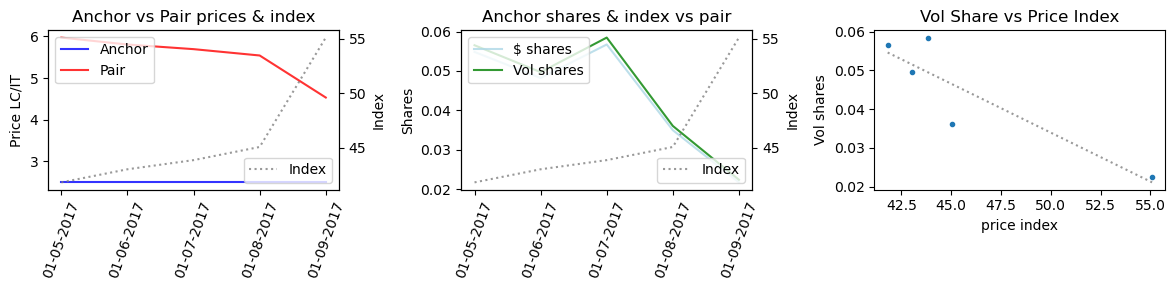

In [20]:
anchor = anchors[0]
pair = 'bed5'

merged_df = evaluate_pairs(filtered_df, anchor, pair)

# Function get_liner_model

In [21]:
def get_linear_model(df):

    X = df[['index']]
    y = df['vol_share_anchor']

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=41)

    model = LinearRegression()

    model.fit(X_train, y_train)
    # print(model.score(X_test, y_test))
    
    plt.figure(figsize=(4,2))

    y_predicted = model.predict(df[['index']])

    plt.plot(df['index'], y_predicted, color='blue', label='Predicted')
    plt.scatter(df['index'], df['vol_share_anchor'], marker='.', color='red', label='Actual')
    plt.legend()

    plt.ylabel('vol shares')
    plt.xlabel('price index')
    plt.title('Vol Share vs Price Index')
    plt.show()

    return model

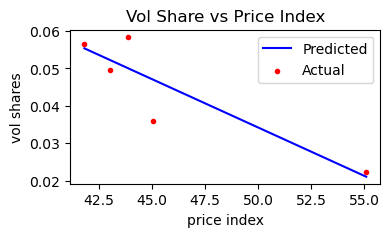

In [22]:
model = get_linear_model(merged_df)

# Step 4: Identify Optimal Price Index vs Pair for each Anchor
During this step, we will identify the price index that optimizes for NOS or GC.

In [23]:
def find_optimal_ix(financials, merged_df, anchor):
    anchor_base_lp = financials[financials['PRODUCT NAME'] == anchor.strip()]['LP per IT'].values[0]
    anchor_nos_per_su = financials[financials['PRODUCT NAME'] == anchor.strip()]['NOS per SU'].values[0]
    anchor_tdc_per_su = financials[financials['PRODUCT NAME'] == anchor.strip()]['TDC per SU'].values[0]
    # print(f'list price lc per it {anchor_base_lp}')
    # print(f'nos $ per su {anchor_nos_per_su}')
    # print(f'tdc $ per su {anchor_tdc_per_su}')

    # min = round(merged_df['index'].min()/10,0)*10
    # max = round(merged_df['index'].max()/10,0)*10
    min = 10
    max = 200
    # outer_range = (max - min)/2
    # tick = ((max + outer_range) - (min - outer_range))/5
    # tick = tick.astype(int)
    index_scenarios = [(min)]
    for i in range(34):
        index_scenarios.append((min) + (i+1)*5)

    merged_df_period = merged_df

    anchor_base_price_point = (merged_df_period['sales_mlc_anchor'].sum() / merged_df_period['sales_msu_anchor'].sum()) / \
                (36 / int(merged_df['count_anchor'][0]))
    pair_base_price_point = (merged_df_period['sales_mlc_pair'].sum() / merged_df_period['sales_msu_pair'].sum()) / \
                (36 / int(merged_df['count_pair'][0]))
    anchor_base_vol_share = model.predict([[(anchor_base_price_point / pair_base_price_point)*100]])[0]

    merged_df_year = merged_df

    anchor_yr_vol = merged_df_year['sales_msu_anchor'].sum()

    # print(f'index scenarios {index_scenarios}')
    # print(f'anchor vol share {anchor_base_vol_share}')
    # print(f'anchor year volume {anchor_yr_vol}')
    # print(f'anchor price {anchor_base_price_point}')
    # print(f'pair price {pair_base_price_point}')

    scenarios_df = pd.DataFrame(index=index_scenarios)
    
    for i, index in enumerate(index_scenarios):
        scenarios_df.at[index, 'price_point_lc'] = round(pair_base_price_point * index / 100, 2)
        scenarios_df.at[index, 'gs_lc_per_it'] = round(anchor_base_lp *
                                                       scenarios_df.at[index, 'price_point_lc'] /
                                                       anchor_base_price_point, 2)
        scenarios_df.at[index, 'vol_share'] = model.predict([[index]])[0]
        scenarios_df.at[index, 'incr_vol'] = (anchor_yr_vol * scenarios_df.at[index, 'vol_share'] / anchor_base_vol_share) - \
                                        anchor_yr_vol
        
    #         print(f'index: {index}')
    #         print(f'pair_sku_current_price_point: {pair_sku_current_price_point}')
    #         print(f'base_sku_yr_msu: {base_sku_yr_msu}')
    #         print(f'base_sku_vol_share: {base_sku_vol_share}')
    #         print(f"scenario vol share: {scenarios_df.at[index, 'vol_share']}")
        
        scenarios_df.at[index, 'nos_per_su'] = anchor_nos_per_su * \
                                        scenarios_df.at[index, 'price_point_lc'] / \
                                        anchor_base_price_point
        scenarios_df.at[index, 'incr_nos'] = (anchor_yr_vol * scenarios_df.at[index, 'vol_share'] / anchor_base_vol_share) * \
                                        scenarios_df.at[index, 'nos_per_su'] - \
                                        (anchor_yr_vol * anchor_nos_per_su)
        scenarios_df.at[index, 'gm_%'] = '{:.2%}'.format((scenarios_df.at[index, 'nos_per_su'] - anchor_tdc_per_su) /
                                        scenarios_df.at[index, 'nos_per_su'])
        scenarios_df.at[index, 'incr_gm'] = ((scenarios_df.at[index, 'nos_per_su'] - anchor_tdc_per_su) *
                                        (anchor_yr_vol * scenarios_df.at[index, 'vol_share'] / anchor_base_vol_share)) - \
                                        ((anchor_nos_per_su - anchor_tdc_per_su) * 
                                        anchor_yr_vol)
    
    fig, ax1 = plt.subplots(figsize=(4, 2))
    
    ax1.plot(scenarios_df.index, scenarios_df['incr_nos'], label='incr nos', color='blue', alpha=0.8)
    ax1.plot(scenarios_df.index, scenarios_df['incr_gm'], label='incr gc', color='green', alpha=0.8)
    
    ax1.set_ylabel('$M')
    ax1.legend(loc='lower left')
    
    ax2 = ax1.twinx()
    ax2.plot(scenarios_df.index, scenarios_df['incr_vol'], label='incr vol', color='black', alpha=0.8)
    ax2.set_ylabel('MSU')
    ax2.legend(loc='upper right')
    
    max_incr_nos = scenarios_df['incr_nos'].max()
    max_incr_gm = scenarios_df['incr_gm'].max()
    
    max_incr_nos_index = scenarios_df.index[scenarios_df['incr_nos'] == max_incr_nos].tolist()
    max_incr_gm_index = scenarios_df.index[scenarios_df['incr_gm'] == max_incr_gm].tolist()
    
    print(f"Max incr_nos: {max_incr_nos:.2f}, Index: {max_incr_nos_index}")
    print(f"Max incr_gc: {max_incr_gm:.2f}, Index: {max_incr_gm_index}")
    
    highlight_max_nos = max_incr_nos_index
    highlight_max_gm = max_incr_gm_index
    
    ax1.axvline(x=highlight_max_nos, color='blue', linestyle='dotted', alpha=0.3)
    ax1.axvline(x=highlight_max_gm, color='green', linestyle='dotted', alpha=0.3)
    
    # # Set y-axis limits symmetrically around zero
    # y1_min, y1_max = ax1.get_ylim()
    # y1_lim = max(abs(y1_min), abs(y1_max))
    # ax1.set_ylim(-y1_lim, y1_lim)
    
    # y2_min, y2_max = ax2.get_ylim()
    # y2_lim = max(abs(y2_min), abs(y2_max))
    # ax2.set_ylim(-y2_lim, y2_lim)
    
    # Add horizontal line at zero position on y-axis
    ax1.axhline(y=0, color='black', linestyle='dotted', alpha=0.1)
    
    plt.title('Incr NOS, GC, Vol scenarios')
    plt.show()

    return scenarios_df

In [24]:
# dummy financials
data = {
    'PRODUCT NAME': ['bed2', 'watches6', 'furniture2'],
    'LP per IT': [80, 110, 60],
    'NOS per SU': [75, 100, 50],
    'TDC per SU': [30, 55, 40]
}
financials = pd.DataFrame(data)
financials
anchor

'bed2'

Max incr_nos: 4513.35, Index: [30]
Max incr_gc: 560.04, Index: [40]


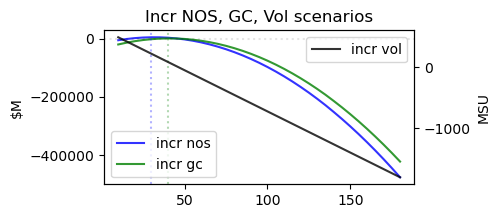

,price_point_lc,gs_lc_per_it,vol_share,incr_vol,nos_per_su,incr_nos,gm_%,incr_gm
10,0.54,17.30,0.137685,485.162482,16.218020,-5592.698569,-84.98%,-20147.573027
15,0.81,25.95,0.124748,418.063468,24.327030,-1433.867582,-23.32%,-13975.771620
20,1.08,34.60,0.111812,350.964454,32.436040,1636.750252,7.51%,-8892.183366
25,1.35,43.25,0.098876,283.865440,40.545050,3619.154933,26.01%,-4896.808264
30,1.62,51.90,0.085940,216.766426,48.654060,4513.346462,38.34%,-1989.646315
35,1.89,60.55,0.073004,149.667412,56.763070,4319.324838,47.15%,-170.697519
40,2.16,69.20,0.060068,82.568398,64.872080,3037.090061,53.76%,560.038124
45,2.43,77.85,0.047132,15.469384,72.981090,666.642131,58.89%,202.560615
50,2.71,86.82,0.034196,-51.629630,81.390434,-2738.748651,63.14%,-1189.859747
55,2.98,95.47,0.021259,-118.728644,89.499444,-7305.774981,66.48%,-3743.915657


In [25]:
find_optimal_ix(financials, merged_df, anchor)

# Anchor 1

In [26]:
anchor = anchors[1]
correlation_1 = get_correlation(filtered_df, anchor, all_products)
correlation_1

,product_anchor,product_pair,ix_val_share_corr,ix_vol_share_corr,val_share_anchor,val_share_pair,price_anchor,price_pair,val_share_ix,price_ix
0,watches6,watches5,-0.752200,-0.782424,0.012967,0.014677,132.842444,213.528069,0.88,0.62
0,watches6,watches4,-0.669238,-0.678086,0.012967,0.011534,132.842444,106.242857,1.12,1.25
0,watches6,watches3,-0.536037,-0.570706,0.012967,0.004006,132.842444,77.988095,3.24,1.70
0,watches6,watches7,-0.264821,-0.263403,0.012967,0.012695,132.842444,305.746871,1.02,0.43
0,watches6,watches2,-0.153841,-0.193126,0.012967,0.006614,132.842444,144.645911,1.96,0.92
0,watches6,watches1,-0.056465,-0.106730,0.012967,0.009008,132.842444,180.627427,1.44,0.74
0,watches6,watches8,0.217038,0.213662,0.012967,0.009158,132.842444,184.504880,1.42,0.72


Anchor: watches6
Pair: watches5


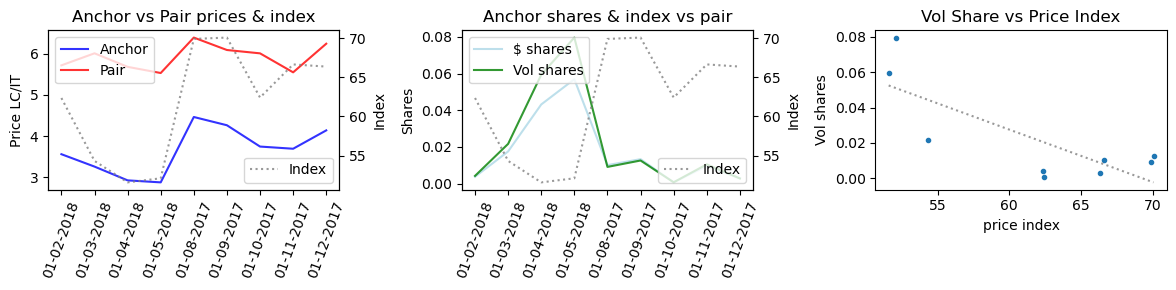

In [27]:
pair = 'watches5'
print(f'Anchor: {anchor}')
print(f'Pair: {pair}')
merged_df = evaluate_pairs(filtered_df, anchor, pair)

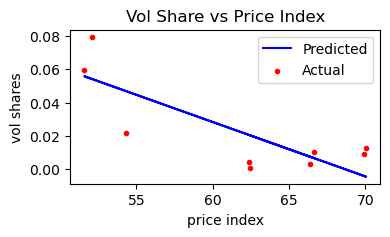

In [28]:
model = get_linear_model(merged_df)

Max incr_nos: 13593.22, Index: [35]
Max incr_gc: 730.97, Index: [50]


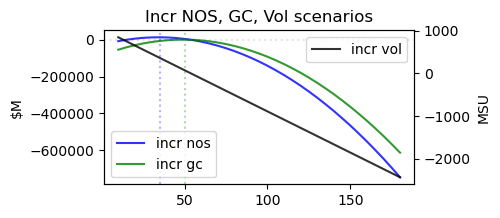

In [29]:
optimal_ix = find_optimal_ix(financials, merged_df, anchor)

# Anchor 2

In [30]:
anchor = anchors[2]
correlation_2 = get_correlation(filtered_df, anchor, all_products)
correlation_2

,product_anchor,product_pair,ix_val_share_corr,ix_vol_share_corr,val_share_anchor,val_share_pair,price_anchor,price_pair,val_share_ix,price_ix
0,furniture2,furniture4,-0.770827,-0.767487,0.050821,0.016945,77.508995,96.156905,3.0,0.81
0,furniture2,furniture3,-0.557163,-0.559344,0.050821,0.005135,77.508995,36.672076,9.9,2.11
0,furniture2,furniture1,-0.540964,-0.543924,0.050821,0.008327,77.508995,36.727775,6.1,2.11


Anchor: furniture2
Pair: furniture4


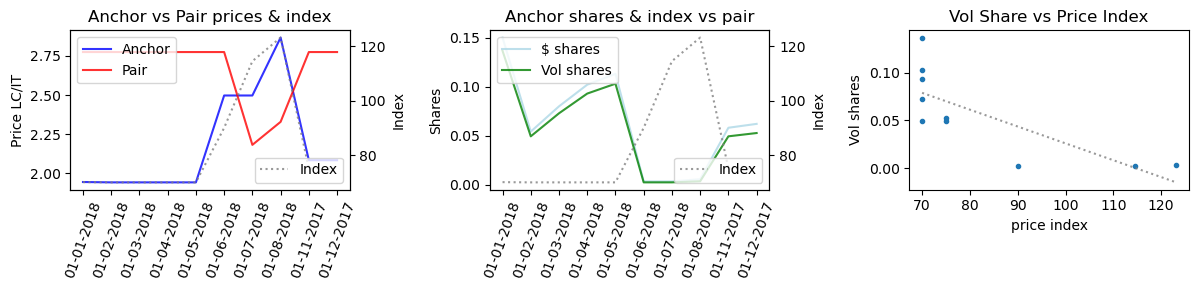

In [31]:
pair = correlation_2['product_pair'].values[0]
print(f'Anchor: {anchor}')
print(f'Pair: {pair}')
merged_df = evaluate_pairs(filtered_df, anchor, pair)

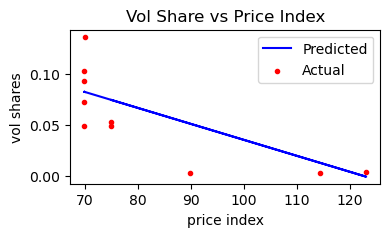

In [32]:
model = get_linear_model(merged_df)

Max incr_nos: 1210.56, Index: [60]
Max incr_gc: 1933.74, Index: [90]


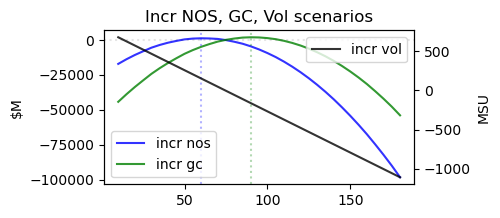

In [33]:
optimal_ix = find_optimal_ix(financials, merged_df, anchor)